# Vineyards navigation with semantic segmentation

Using semantic segmentation for a proportional controller along the vineyard rows.




- This notebook contains scripts to create, train, and test a deep learning network to perform fast semantic segmentation on platform with mobile CPUs and low memory capabilities

- The implemented architecture is a MobileNetV3 with a customized LR-ASSP

# 0 Initialization

In [1]:
#Required libraries

import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm as tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

2022-11-03 15:39:50.846935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 15:39:50.961775: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 15:39:50.993359: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 15:39:51.530883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
#select the working GPU

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)


Num GPUs Available:  4


# 1.0 Import the dataset

In [3]:
PATH_DIR = 'dataset/aghi_mod/'
training_img_dir = os.path.join(PATH_DIR, 'images/train')
training_mask_dir = os.path.join(PATH_DIR, 'masks/train')
test_img_dir = os.path.join(PATH_DIR, 'images/test')
test_mask_dir = os.path.join(PATH_DIR, 'masks/test')

In [4]:
train_img_list = glob.glob(os.path.join(training_img_dir, '*.jpg'))
train_mask_list = glob.glob(os.path.join(training_mask_dir, '*.jpg'))

test_img_list = glob.glob(os.path.join(test_img_dir, '*.jpg'))
test_mask_list = glob.glob(os.path.join(test_mask_dir, '*.jpg'))


# print(train_img_list)

## 1.1 Load images and masks in two separate arrays

In [5]:
def loadData(imgList, maskList):
    X = []
    y = []
    name_X = []
    for i in tqdm(imgList):
        for j in maskList:
            img_name = os.path.split(i)[1].split('.jpg')[0]#.split('_')[1]
            mask_name = os.path.split(j)[1].split('.jpg')[0]#.split('_')[1]

            if img_name == mask_name:            
                img = cv2.imread(i)
                mask = cv2.imread(j,0)
                X.append(img)
                y.append(mask)
                name_X.append(os.path.split(i)[1].split('.jpg')[0])
        
        
        
    return (np.array(X), np.array(y))

In [6]:
#X,y are for training and validation
X, y = loadData(train_img_list, train_mask_list)

#X_test,y_test are for testing
X_test, y_test = loadData(test_img_list, test_mask_list)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## 1.2 Shuffle dataset

In [7]:
#mask and image must be shuffled with the same index
def custom_shuffle(img_array, mask_array):
    assert len(img_array) == len(mask_array)
    p = np.random.permutation(len(img_array))
    return img_array[p], mask_array[p]

In [8]:
X,y=custom_shuffle(X,y)
X_test,y_test=custom_shuffle(X_test,y_test)

# 2.0 Visualize the dataset

In [9]:
img = X[0]
mask = y[0]

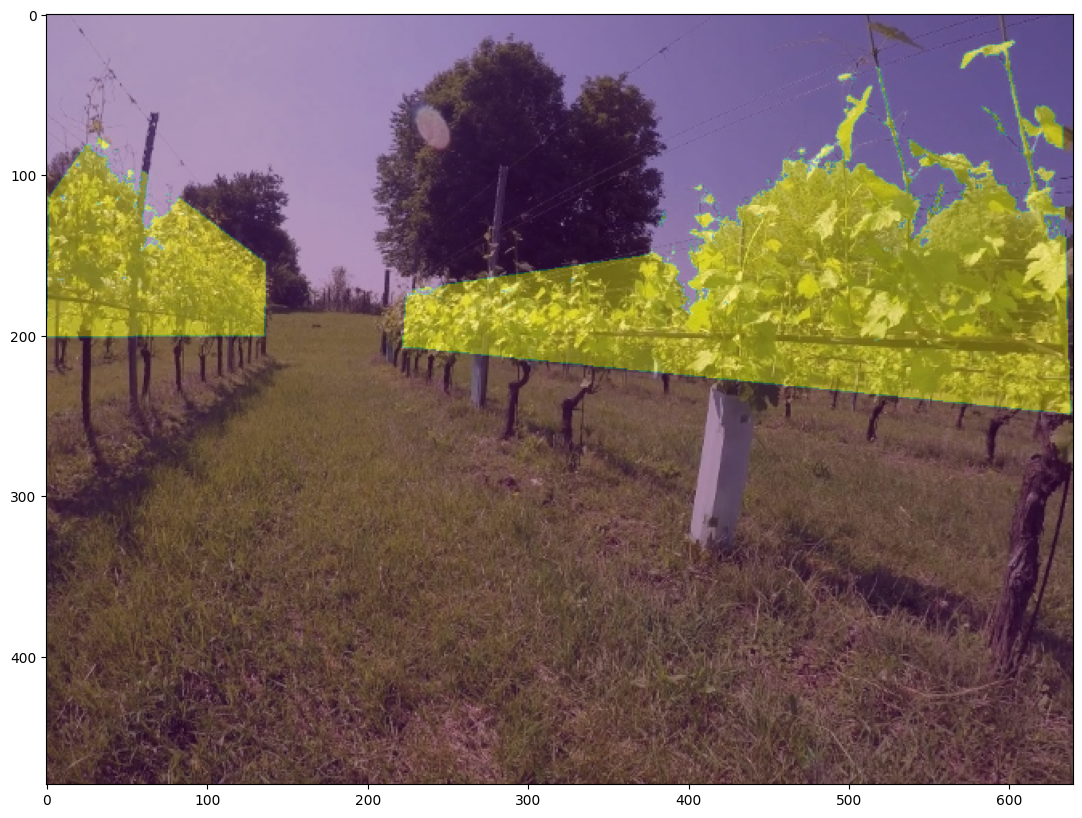

In [10]:
# show the mask over the image
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(mask, alpha=0.4)
plt.show()

# 3.0 Pre-process the dataset

In [11]:
#input shape network
in_net_h=224
in_net_w=224
net_channels=3

In [12]:
#Resize the prediction mantaining the aspect ratio for X

def resizeImage(X, width, force_dim=False, height = None):
    X_res = []
    for img in tqdm(X):
        r = width / img.shape[1]
        dim = (width, int(img.shape[0] * r))
        # not mantain the ratio
        if force_dim:
            img_resized = cv2.resize(img.astype('uint8'), (width,height), interpolation = cv2.INTER_AREA)
        else:
            img_resized = cv2.resize(img.astype('uint8'), dim, interpolation = cv2.INTER_AREA)
        X_res.append(img_resized)
        
    return np.array(X_res)

In [13]:
#Resize the prediction mantaining the aspect ratio for y
def resizeImage_y(y, width, force_dim=False, height = None):
    y_res = []
    for img,img1 in tqdm(zip(y[:,0],y[:,1])):
        
        
        r = width / img.shape[1]
        dim = (width, int(img.shape[0] * r))
        # not mantain the ratio
        if force_dim:
            img_resized = cv2.resize(img.astype('uint8'), (width,height), interpolation = cv2.INTER_AREA)
        else:
            img_resized = cv2.resize(img.astype('uint8'), dim, interpolation = cv2.INTER_AREA)
            
        r = width / img1.shape[1]
        dim = (width, int(img1.shape[0] * r))
        # not mantain the ratio
        if force_dim:
            img_resized1 = cv2.resize(img1.astype('uint8'), (width,height), interpolation = cv2.INTER_AREA)
        else:
            img_resized1 = cv2.resize(img1.astype('uint8'), dim, interpolation = cv2.INTER_AREA)
            
            
        y_res.append([img_resized,img_resized1])
    
    return np.array(y_res)

In [14]:
def normalize(X):
    return (X / 255)

## 3.1 Resize the dataset

In [15]:
#Resize the images and masks with the accepted dimensions by the network

X = resizeImage(X, in_net_w, force_dim=True, height = in_net_h)
X_test = resizeImage(X=X_test,width= in_net_w, force_dim=True, height = in_net_h)

y = resizeImage(y, in_net_w, force_dim=True, height = in_net_h)
y_test = resizeImage(X=y_test, width=in_net_w, force_dim=True, height = in_net_h)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## 3.2 Normalize the dataset

In [16]:
X = normalize(X)
X_test = normalize(X=X_test)

In [17]:
y= normalize(y)
y_test= normalize(X=y_test)

In [18]:
#Apply a threshold to have 0,1 despite the resizing
y[y>=(0.5)]=1.0    
y[y<(0.5)]=0.0

#Apply a threshold to have 0,1 despite the resizing
y_test[y_test>=(0.5)]=1.0
y_test[y_test<(0.5)]=0.0

# 4.0 Build and Train model

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from datetime import datetime

from tensorflow.keras.models import Model,load_model

from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Activation, Input, Add, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape,Dropout, Multiply, Flatten,UpSampling2D
from tensorflow.keras.losses import BinaryCrossentropy


from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.utils import get_custom_objects

In [20]:
#import network
from tensorflow.keras.applications import MobileNetV3Large

In [21]:
#Save checkpoints

model_dir = os.path.join(PATH_DIR, 'bin')

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
name = 'MobileNet_V3'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "logs"
logdir = "{}/run-{}_{}/".format(root_logdir, now,name)

backup_model_path = os.path.join(model_dir, '{}.h5'.format(name))
backup_weights_path = os.path.join(model_dir, '{}_weights.h5'.format(name))


checkpointer = ModelCheckpoint(filepath=backup_weights_path, 
                               monitor = 'loss',
                               verbose=1, 
                               save_best_only=True)

## 4.1 Building model

In [22]:
#Define custom activation function
def hard_swish(x):
    return x * tf.nn.relu6(x + 3) / 6

In [23]:
#Defining dropout_r
dropout_r=0.2

#Base model mobile net
model_base= MobileNetV3Large(input_shape=(in_net_w,in_net_h,3),
                     alpha=1.0,
                     minimalistic=False,
                     include_top=False,
                     weights='imagenet',
                     input_tensor=None,
                     classes=1,
                     pooling='avg',
                     dropout_rate=dropout_r)
model_base.summary()

2022-11-03 15:39:58.866015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 15:39:59.722681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38176 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:61:00.0, compute capability: 8.0


Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_29[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_15[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_33 

 tf.math.multiply_25 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_36[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_18 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

In [24]:
activation_number=41

#Adding segmentation head

def buildModel(base_model, dropout_rate= dropout_r, n_class=1): 
    global activation_number
    #1/8 resolution output
    
    out_1_8= base_model.get_layer('re_lu_15').output #'activation_15'
    
    #1/16 resolution output
    
    out_1_16= base_model.get_layer('re_lu_29').output #'activation_29'
    
    
    # branch1
    x1 = Conv2D(128, (1, 1))(out_1_16)
    x1 = BatchNormalization()(x1)
    
    layer_name_act="activation_head"+str(activation_number)
    x1 = Activation('relu',name=layer_name_act)(x1)
    activation_number+=1
    
    # branch2
    s = x1.shape

    #custom average pooling2D
    x2 = AveragePooling2D(pool_size=(12, 12), strides=(4, 5),data_format='channels_last')(out_1_16)
    x2 = Conv2D(128, (1, 1))(x2)
    
    
    layer_name_act="activation_head"+str(activation_number)
    
    x2 = Activation('sigmoid',name=layer_name_act)(x2)
    activation_number+=1
    

    x2 = UpSampling2D(size=(int(s[1]), int(s[2])),data_format='channels_last',interpolation="bilinear")(x2)

    
    
    # branch3
    x3 = Conv2D(n_class, (1, 1))(out_1_8)
    
    # multiply
    m1 = Multiply()([x1, x2])

    m1 = UpSampling2D(size=(2, 2),data_format='channels_last',interpolation="bilinear")(m1)
    m1 = Conv2D(n_class, (1, 1))(m1)

    # add
    m2 = Add()([m1, x3])

    
    #adding this UPsampling of factor 8
    m2 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(m2)

    
    # predictions 
    layer_name_act="activation_head"+str(activation_number)
    predictions = Activation('sigmoid',name=layer_name_act)(m2)
    
    
    activation_number+=1 


    # final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [25]:
model=buildModel(base_model=model_base)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 672)   0           ['re_lu_29[0][0]']               
 ing2D)                                                                                           
          

## 4.2 Training model

In [27]:
#Define the optimizers
optimizer_r = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer_a = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
optimizer_SDG=SGD(learning_rate=0.01, momentum=0.0, nesterov=False)


/home/szilard/anaconda3/envs/deepseg/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/szilard/anaconda3/envs/deepseg/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [28]:
def loss_IoU(y_true, y_pred): 
    
    intersection_tensor=tf.math.multiply(y_true,y_pred)
    inter=tf.reduce_sum(intersection_tensor)
    
    union=tf.reduce_sum(tf.math.subtract(tf.math.add(y_true,y_pred),intersection_tensor))
    
    
    iou= tf.math.divide(inter,union)
    return 1-iou

In [29]:
#metric
def class_IoU(y_true, y_pred):

    
    threshold = tf.constant([0.9])
    y_pred_threshold=tf.cast(tf.math.greater(y_pred, threshold),tf.int32)
    y_true=tf.cast(y_true,tf.int32)
    

    intersection_tensor=tf.math.multiply(y_true,y_pred_threshold)
    inter=tf.reduce_sum(intersection_tensor)
    
    #union= a+b-intersection
    union=tf.reduce_sum(tf.math.subtract(tf.math.add(y_true,y_pred_threshold),intersection_tensor))
    
    
    return tf.math.divide(inter,union)

### 4.2.1 Transfer learning: freeze the lower layers


Freezing the lower layers for a few epochs and then train the whole model


In [30]:
#Compile the model 
model.compile(optimizer=optimizer_r, loss=loss_IoU, metrics = [class_IoU])

In [31]:
#The first layers have been already frozen previously

early_stopping_ = tf.keras.callbacks.EarlyStopping(patience=0)

n_epochs = 100

# Train the model on the new data for a few epochs
history_F = model.fit(x = X, y = y,
                    batch_size = 64,
                    epochs = n_epochs,
                    validation_split = 0.1, 
                    shuffle = True,
                    callbacks = [early_stopping_]
                     )  

Epoch 1/100


2022-11-03 15:40:26.363641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8300
2022-11-03 15:40:27.457630: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-03 15:40:27.460725: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2022-11-03 15:40:27.460742: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-03 15:40:27.460809: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

6/6 [==============================] - 10s 268ms/step - loss: 0.6358 - class_IoU: 0.4205 - val_loss: 0.8479 - val_class_IoU: 0.1797
Epoch 2/100
6/6 [==============================] - 1s 90ms/step - loss: 0.3186 - class_IoU: 0.6720 - val_loss: 0.8485 - val_class_IoU: 0.1780
Epoch 3/100
6/6 [==============================] - 1s 91ms/step - loss: 0.2873 - class_IoU: 0.7060 - val_loss: 0.8421 - val_class_IoU: 0.2320
Epoch 4/100
6/6 [==============================] - 1s 91ms/step - loss: 0.2672 - class_IoU: 0.7257 - val_loss: 0.8416 - val_class_IoU: 0.2042
Epoch 5/100
6/6 [==============================] - 1s 92ms/step - loss: 0.2649 - class_IoU: 0.7307 - val_loss: 0.8394 - val_class_IoU: 0.0892
Epoch 6/100
6/6 [==============================] - 1s 92ms/step - loss: 0.2533 - class_IoU: 0.7404 - val_loss: 0.8414 - val_class_IoU: 0.0998
Epoch 7/100
6/6 [==============================] - 1s 95ms/step - loss: 0.2560 - class_IoU: 0.7402 - val_loss: 0.8633 - val_class_IoU: 0.0757
Epoch 8/100
6/6 

# 5.0 Test the Model


Test the model in different vineyard parcels

In [32]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 15ms/step - loss: 0.9272 - class_IoU: 0.0363


[0.927245557308197, 0.03627919405698776]

# 6.0 Compute metrics for paper

## 6.1 Pixel accuracy


In [33]:
acc_list=[]
for jj in tqdm(range(len(X_test))):
    y_pred = model.predict(X_test[jj][None,...])
    y_pred = (y_pred[0,:,:,0] > 0.9)
    temp=np.equal(y_pred,y_test[jj])
    score=np.sum(temp)
    accuracy=score/(224**2)
    acc_list.append(accuracy)

acc_nump=np.array(acc_list)
np.mean(acc_nump)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


0.8224125079719387

## 6.2 Precision @ different thresholds


In [34]:
iou_list=[]
for jj in tqdm(range(len(X_test))):
    y_pred = model.predict(X_test[jj][None,...])
    iou=class_IoU(y_test[jj], y_pred[0,:,:,0])
    iou_list.append(iou.numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


In [35]:
iou_list=np.array(iou_list)
print("iou greater 0.4 and %")
a1=len(np.where(iou_list>0.4)[0])
print(a1,a1/500)
print("iou greater 0.5 and %")
a1=len(np.where(iou_list>0.5)[0])
print(a1,a1/500)
print("iou greater 0.6 and %")
a1=len(np.where(iou_list>0.6)[0])
print(a1,a1/500)
print("iou greater 0.7 and %")
a1=len(np.where(iou_list>0.7)[0])
print(a1,a1/500)

iou greater 0.4 and %
0 0.0
iou greater 0.5 and %
0 0.0
iou greater 0.6 and %
0 0.0
iou greater 0.7 and %
0 0.0


# 7.0 save model

In [36]:
#Saving the model
cwd = os.getcwd()
model_path = os.path.join(cwd,'bin','mobileNetv3_segmentation_new1.h5')
model.save(model_path, save_format='h5')

# 8.0 Test on a random image

In [37]:
cwd = os.getcwd()
print(cwd)
model_path = os.path.join(cwd,'bin','mobileNetv3_segmentation_new1.h5')
model=tf.keras.models.load_model(model_path,
                                 custom_objects={"hard_swish": hard_swish,"loss_IoU": loss_IoU,"class_IoU":class_IoU}
                                )

/home/szilard/projects/deep_segmentation_vineyards_navigation


In [38]:
x_test_new = cv2.imread('datasets_segmentation/test/img_95.jpg') 
# x_test_new = X[0]
x_test_new = cv2.cvtColor(x_test_new, cv2.COLOR_BGR2RGB)
x_test_new = cv2.resize(x_test_new.astype('uint8')
                        , (224,224), interpolation = cv2.INTER_AREA)
x_test_new = normalize(x_test_new)

In [39]:
def plotPrediction(x, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(15,15))
    axes[0].imshow(x)
    axes[1].imshow(y_pred)

1/1 [==============================] - 1s 549ms/step


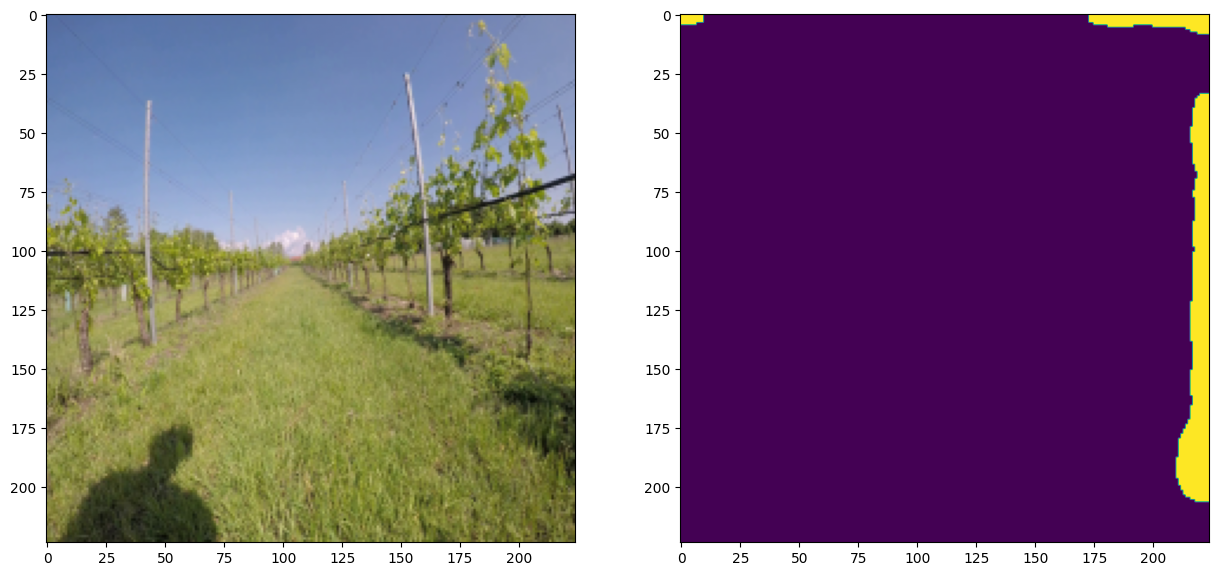

In [40]:
y_pred = model.predict(x_test_new[None,...])
y_pred = (y_pred > 0.9)
plotPrediction(x_test_new, y_pred[0,:,:,0])

# 8.0 Vegetation index

In [ ]:
#Datasets_segmentation/training_dataset
img_test = cv2.imread('vegetation_index/frame_5260.jpg')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test.astype('uint8'), (224,224), interpolation = cv2.INTER_AREA)
img_test = normalize(img_test)


In [ ]:
y_pred = model.predict(x_test_new[None,...])
y_pred = (y_pred > 0.9)
plotPrediction(x_test_new, y_pred[0,:,:,0])

In [ ]:
img = cv2.imread('vegetation_index/frame_11115.jpg')

x_test_new = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x_test_new = cv2.resize(x_test_new.astype('uint8'), (224,224), interpolation = cv2.INTER_AREA)
x_test_new = normalize(x_test_new)
img = cv2.resize(img.astype('uint8'), (224,224), interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
y_pred = model.predict(x_test_new[None,...])
y_pred = (y_pred > 0.9)

#Show the mask over the image
plt.figure(figsize=(8,8),frameon=False)
plt.axis('off')
plt.imshow(img)

#Remove pink from sky
rem_pred=y_pred[0,:,:,0].astype(np.float)

rem_pred[rem_pred==0]=np.NaN
plt.imshow(rem_pred, alpha=0.4,cmap='Spectral')

plt.savefig('s_veg2.png', bbox_inches='tight', pad_inches=0)

In [ ]:
#Reverse colours
gira=cv2.imread('s_veg2.png')
gira=cv2.cvtColor(gira, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8),frameon=False)
plt.axis('off')
plt.imshow(gira)
plt.savefig('s_veg2.png', bbox_inches='tight', pad_inches=0)

In [ ]:
output=y_pred[0,:,:,0]

In [ ]:
#Compute vegetation index
veg=np.zeros((224,224))

for x,y in zip(np.where(output)[0],np.where(output)[1]):
    veg[x,y]=(img[x,y,1]-img[x,y,0])/(img[x,y,1]+img[x,y,0]-img[x,y,2])


In [ ]:
#Remove outliers 
veg[veg>1]=np.NaN 
veg[veg==0]=np.NaN
veg[veg==np.inf]=np.NaN

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Normalize
min_max_scaler = MinMaxScaler()
map_veg = min_max_scaler.fit_transform(veg)

In [ ]:
plt.figure(figsize=(8,8))
plt.axis('off')

cf=plt.imshow(map_veg,cmap='inferno')
cd= plt.colorbar(cf)

cd.set_ticklabels(['LOW','HIGH'])
plt.show()